In [1]:
#@title Load the imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

print("Ran the import statements.")

Ran the import statements.


In [2]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66900.0
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80100.0
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85700.0
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73400.0
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65500.0


In [3]:
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,2.6,-0.7,-1.1,1.4,1.8,-0.4,-0.1,-1.3,-1.2
1,2.5,-0.6,-0.8,2.3,3.2,-0.3,-0.1,-1.1,-1.1
2,2.5,-0.9,-0.9,-0.9,-0.9,-1.0,-1.0,-1.2,-1.0
3,2.5,-0.9,-1.2,-0.5,-0.5,-0.8,-0.7,-0.4,-1.2
4,2.5,-1.0,-0.7,-0.5,-0.5,-0.7,-0.6,-1.0,-1.2


In [4]:
test_df_norm = (train_df_norm - train_df_mean)/train_df_std
test_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,60.9,-17.0,-2.4,-1.2,-1.3,-1.2,-1.3,-2.7,-1.8
1,60.9,-16.9,-2.3,-1.2,-1.3,-1.2,-1.3,-2.6,-1.8
2,60.9,-17.1,-2.3,-1.2,-1.3,-1.2,-1.3,-2.6,-1.8
3,60.9,-17.1,-2.4,-1.2,-1.3,-1.2,-1.3,-2.2,-1.8
4,60.9,-17.1,-2.3,-1.2,-1.3,-1.2,-1.3,-2.6,-1.8


In [5]:
threshhold_in_z = 1.0
train_df_norm['median_house_value_high'] = (train_df_norm['median_house_value']>threshhold_in_z).astype(float)
test_df_norm['median_house_value_high'] = (test_df_norm['median_house_value']>threshhold_in_z).astype(float)
test_df_norm['median_house_value_high'].head(8000)

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
        ..
7995   0.0
7996   0.0
7997   0.0
7998   0.0
7999   0.0
Name: median_house_value_high, Length: 8000, dtype: float64

train_df_norm.columns()

In [8]:
train_df_norm.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')

In [11]:
train_df_norm['longitude'].head()

0   2.6
1   2.5
2   2.5
3   2.5
4   2.5
Name: longitude, dtype: float64

In [11]:
inputs = {
# Features used to train the model on.
  'median_income': tf.keras.Input(shape=(1,)),
  'total_rooms': tf.keras.Input(shape=(1,))
}

In [28]:
#@title Define the functions that create and train a model.
def create_model(my_inputs, my_learning_rate, METRICS):
  # Use a Concatenate layer to concatenate the input layers into a single tensor.
  # as input for the Dense layer. Ex: [input_1[0][0], input_2[0][0]]
  concatenated_inputs = tf.keras.layers.Concatenate()(my_inputs.values())
  dense = layers.Dense(units=1, name='dense_layer', activation=tf.sigmoid)
  dense_output = dense(concatenated_inputs)
  """Create and compile a simple classification model."""
  my_outputs = {
    'dense': dense_output,
  }
  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)

  # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression.
  model.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=my_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=METRICS)
  return model



In [18]:
def train_model(model, dataset, epochs, label_name, batch_size = None, shuffle=True):
    
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size = batch_size, epochs = epochs, shuffle = shuffle)

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # Isolate the classification metric for each epoch.
    hist = pd.DataFrame(history.history)

    return epochs, hist

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


In [33]:
def plot_the_curve(epoch, hist, list_of_metrics):
    plt.figure()
    plt.xlabel("epoch")
    plt.ylabel("value")
    
    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)
        
    plt.legend()    
print("Defined the plot_curve function.")

Defined the plot_curve function.


Epoch 1/20
170/170 [==============================] - 2s 2ms/step - loss: 0.8744 - accuracy: 0.2231 - precision: 0.1139 - recall: 0.5538 - auc: 0.2583
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.7474 - accuracy: 0.2395 - precision: 0.1214 - recall: 0.5862 - auc: 0.2838
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.6389 - accuracy: 0.2786 - precision: 0.1367 - recall: 0.6424 - auc: 0.3534
Epoch 4/20
170/170 [==============================] - 1s 3ms/step - loss: 0.5498 - accuracy: 0.4014 - precision: 0.1695 - recall: 0.6835 - auc: 0.5484
Epoch 5/20
170/170 [==============================] - 0s 3ms/step - loss: 0.4804 - accuracy: 0.7276 - precision: 0.3252 - recall: 0.6208 - auc: 0.7413
Epoch 6/20
170/170 [==============================] - 0s 3ms/step - loss: 0.4278 - accuracy: 0.8466 - precision: 0.5277 - recall: 0.5798 - auc: 0.8221
Epoch 7/20
170/170 [==============================] - 0s 3ms/step - loss: 0.3912 - accuracy: 0

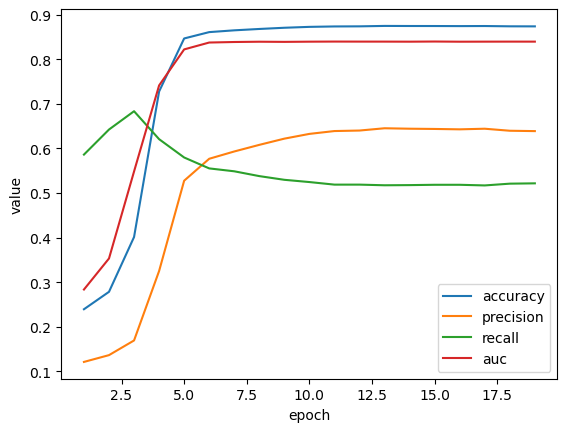

In [35]:
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_high"
classification_threshold = 0.35

# Establish the metrics the model will measure.
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy',threshold=classification_threshold),
    tf.keras.metrics.Precision(thresholds=classification_threshold, name='precision'),
    tf.keras.metrics.Recall(thresholds = classification_threshold, name = "recall"),
    tf.keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
my_model = create_model(inputs, learning_rate, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs,
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall", "auc"]
plot_the_curve(epochs, hist, list_of_metrics_to_plot)


#Experiment with different values for classification_threshold in the code cell within 
#"Invoke the creating, training, and plotting functions." What value of classification_threshold 
#produces the highest accuracy?

# A `classification_threshold` of slightly over 0.5
# appears to produce the highest accuracy (about 83%).
# Raising the `classification_threshold` to 0.9 drops
# accuracy by about 5%.  Lowering the
# `classification_threshold` to 0.3 drops accuracy by
# about 3%.


In [1]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.
